# Neural Networks with TensorFlow and Keras

텐서플로우는 Keras API를 표준 API로 채택하여 신경망 모형을 간단히 구현할 수 있다. 

## Import Resources

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf


In [3]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [4]:
print(' TensorFlow version:', tf.__version__)
print(' tf.keras version:', tf.keras.__version__)
print(' Running on GPU' if tf.test.is_gpu_available() else ' GPU device not found. Running on CPU')

 TensorFlow version: 2.3.0
 tf.keras version: 2.4.0
 GPU device not found. Running on CPU


## Load the Dataset

MNIST dataset 은 greyscale 이미지로, 손으로 쓴 숫자 데이터 셋이다. 각각의 image는 28x28 pixels 크기이다. 

<img src='./assets/mnist.png'>

우리의 목표는 신경망 모형을 생성하여 각 이미지에 해당 하는 숫자를 분류하는 것이다. 


다음 코드를 사용하면 MNIST dataset을 load 할 수 있다. 

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

## Inspect the Dataset

x_train에는 총 60000개의 28×28 크기의 이미지가 담겨 있다. y_train에는 이 x_train의 60000개에 대한 값(0~9)이 담겨 있는 레이블 데이터셋이다. 그리고 x_train과 y_train은 각각 10000개의 이미지와 레이블 데이터셋이다. 

총 데이터의 갯수를 확인하고 임의로 1개의 데이터 셋을 화면에 출력해본다.

In [6]:
# train image 데이터 셋
x_train.shape

(60000, 28, 28)

In [7]:
# label
y_train.shape

(60000,)

In [8]:
# test image 데이터 셋
x_test.shape

(10000, 28, 28)

In [9]:
y_test.shape

(10000,)

In [10]:
num_classes = 10
print('There are {:,} classes in our dataset'.format(num_classes))

num_training_examples = x_train.shape[0]
print('\nThere are {:,} images in the training set'.format(num_training_examples))

There are 10 classes in our dataset

There are 60,000 images in the training set


In [11]:
X_train = x_train.reshape(num_training_examples, 28, 28,1)
training_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))

`training_set`은 iterator로 반복문으로 access 할 수 있다.


```python
for image, label in training_set:
    ## do things with images and labels
```

 `.take(1)` method를 사용하면 데이터 셋에서 1개의 이미지만 선택할 수 있다.

In [12]:
for image, label in training_set.take(1):
    print('The images in the training set have:')
    print(' dtype:', image.dtype) 
    print(' shape:', image.shape)
  
    print('\nThe labels of the images have:')
    print(' dtype:', label.dtype) 

The images in the training set have:
 dtype: <dtype: 'uint8'>
 shape: (28, 28, 1)

The labels of the images have:
 dtype: <dtype: 'uint8'>


이미지 데이터 셋은 `shape = (28, 28, 1)` 이고 `dtype = uint8`이다. `unit8` 은  8-bit unsigned integer 를 의미하는데 이미지 데이터이므로 이 경우 0~255 사이의 정수값이 들어 있다.

images를 화면에 출력해 보자. 먼저 tensors를 NumPy ndarrays로 변환한다. `.numpy()` method를 활용하자.images 는 `shape = (28, 28, 1)` 인데  `.squeeze()` method 를 사용하여 `shape = (28, 28)`로 형태를 변환해야 한다. `.squeeze()` method 는  single-dimensional 요소를 제거하는 메소드이다. 

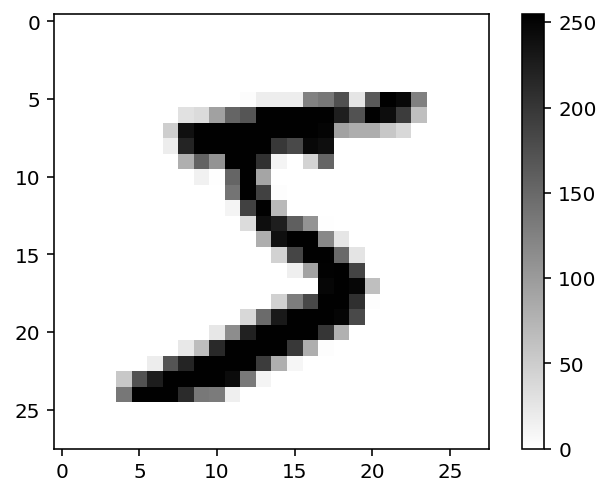

The label of this image is: 5


In [13]:
for image, label in training_set.take(1):
    image = image.numpy().squeeze()
    label = label.numpy()
    
# Plot the image
plt.imshow(image, cmap = plt.cm.binary)
plt.colorbar()
plt.show()

print('The label of this image is:', label)

## Create Pipeline

pixel values 값의 범위는 `[0, 255]` 이다. 신경망 모형의 입력에 맞도록 normalize 해야 한다. 이를 위해서 pixel values를 255로 나눈다. 데이터 타입도 `uint8` 에서 `float32`  (32-bit single-precision floating-point numbers)로 변환한다. 변환에  `tf.cast` function을 활용한다.

In [14]:
def normalize(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255
    return image, label

batch_size = 64

training_batches = training_set.cache().shuffle(x_train.shape[0]//4).batch(batch_size).map(normalize).prefetch(1)

batch size 는 `64`로 지정하고 shuffling을 수행한다. batch size는 한 번의 iteration으로 읽어들이는 이미지의 갯수이다. `shuffle`은 신경망 모형에 입력되는 데이터를 임의로 섞는다는 것이다. 

다음을 참조해 보자.


* [Pipeline Performance](https://www.tensorflow.org/beta/guide/data_performance)


* [Transformations](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

생성된 `training_batches`을 살펴보면 다음과 같다.

In [15]:
for image_batch, label_batch in training_batches.take(1):
    print('The images in each batch have:')
    print(' dtype:', image_batch.dtype) 
    print(' shape:', image_batch.shape)
  
    print('\nThere are a total of {} image labels in this batch:'.format(label_batch.numpy().size))
    print(label_batch.numpy())

The images in each batch have:
 dtype: <dtype: 'float32'>
 shape: (64, 28, 28, 1)

There are a total of 64 image labels in this batch:
[6 1 4 9 3 7 1 7 6 3 7 4 3 5 7 7 4 5 1 7 2 0 1 0 3 5 2 6 8 1 0 8 2 3 0 6 1
 4 2 6 1 9 6 4 7 8 2 8 2 4 7 8 2 0 7 4 7 4 3 1 3 1 4 7]


생성된 batch에서 임의의 이미지를 읽어서 화면에 출력해 보자.

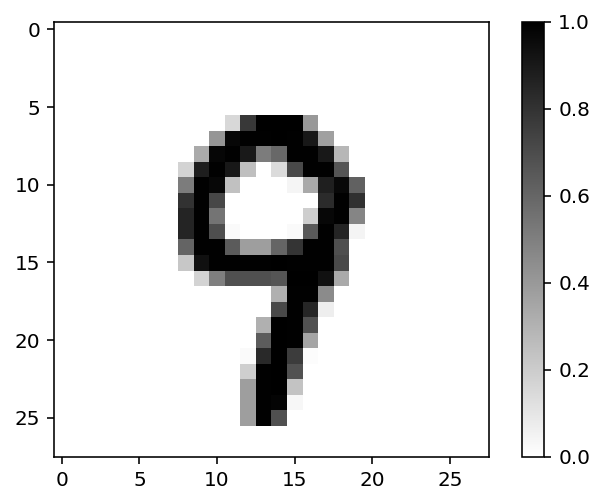

The label of this image is: 9


In [16]:
# Take a single batch of images, and remove the color dimension by squeezing it
for image_batch, label_batch in training_batches.take(1):
    images = image_batch.numpy().squeeze()
    labels = label_batch.numpy()

# Plot the image
plt.imshow(images[0], cmap = plt.cm.binary)
plt.colorbar()
plt.show()

print('The label of this image is:', labels[0])

## Build a Simple Neural Network

아주 단순한 신경망 모형을 작성해 본다.


먼저 weight matrices 와 matrix multiplications을 활용한 간단한 network를 구성한다. 그리고나서 TensorFlow 와 Keras를 사용하여 간단하고 편리하게 network를 구성해 본다.

앞서 배운 network의 형태를 *fully-connected* 또는 *dense* networks라고 한다. 하나의 layer의 unit이 다음 layer의 unit과 모두 연결된 형태이다. 이러한 fully-connected networks에서는 각 layer의 input이 1차원 vector 형태여야 한다. 그러나, 우리의 images 는 28 $\times$ 28 2D tensors이다. 따라서 이를 1D vectors로 변환해야 한다. 즉, images batch `(64, 28, 28, 1)` 를 `(64, 784)` 로 변환한다.이러한 변환을 *flattening*이라고 한다.



분류해야할 숫자가 0~9까지 10개이므로 총 10개의 output units이 필요하다. 또 각 class 별 예측 확률을 리턴하도록 한다.

> **실습하기:** `images` 를 flatten 하여 784 input units으로 한다. 256 hidden units과 10 output units 을 가진 network를 구성한다. 각 weights 와 biases tensor는 random 하게 초기화한다. activation함수는 sigmoid를 사용한다. output layer에는 activation 함수를 쓰지 않는다.   
**HINT:** [`tf.reshape()`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/reshape) function 를 사용하여 input image를 flatten 한다.

In [17]:
## Solution
def activation(x):
    """ Sigmoid activation function
    
        Arguments
        ---------
        x: tf.Tensor. Must be one of the following types: bfloat16, half, float32, float64, complex64, complex128.
    """
    return 1/(1+tf.exp(-x))

In [18]:
# Flatten the input images
inputs = tf.reshape(images, [images.shape[0], -1])

# Print the shape of the inputs. Should be (64,784)
print('The inputs have shape:', inputs.shape)

The inputs have shape: (64, 784)


In [19]:
# Create Neural Network parameters
w1 = tf.random.normal((784,256))
b1 = tf.random.normal((1,256))

w2 = tf.random.normal((256,10))
b2 = tf.random.normal((1,10))

In [20]:
# Perform matrix multiplications for the hidden layer
# and apply activation function
h = activation(tf.matmul(inputs, w1) + b1)

In [21]:
# Perform matrix multiplication for the output layer
output = tf.matmul(h, w2) + b2

# Print the shape of the output. It should be (64,10)
print('The output has shape:', output.shape)

The output has shape: (64, 10)


이제 10개의 output에서 확률을 리턴하도록 한다.

<img src='./assets/image_distribution.png' width=500px>

리턴된 확률을 보면 거의 동일함을 알수 있다. 이유는 우리의 network이 아직 훈련되지 않았으므로 정확한 확률을 리턴하지 않는다.  

확률을 구하기 위해서 [**softmax** function](https://en.wikipedia.org/wiki/Softmax_function)를 사용한다.

$$
\Large \sigma(x_i) = \cfrac{e^{x_i}}{\sum_k^K{e^{x_k}}}
$$


> **실습하기:** `softmax`를 구현한다. 이 작업을 수행 할 때 shape에 주의를 기울여야한다. shape이 (64, 10) 인 텐서 a와 shape이 (64,) 인 텐서 b가있는 경우, a / b를 수행하면 shape이 다르기 때문에 오류가 발생한다. tf.reduce_sum ()에서 axis 키워드를 정의해야한다. axis = 0을 설정하면 행의 합계를 가져오고 axis = 1은 열의 합계를 가져온다.  또한 tf.reduce_sum ()에서 keepdims 키워드를 사용하여 출력 텐서의 모양이 `(64,1)`로 올바르게 출력되도록 한다. 

In [22]:
## Solution
def softmax(x):
    """ Softmax function
    
        Arguments
        ---------
        x: tf.Tensor. Must be one of the following types: bfloat16, half, float32, float64, complex64, complex128.
    """
    
    return tf.exp(x) / tf.reduce_sum(tf.exp(x), axis = 1, keepdims = True)


In [23]:
# Apply softmax to the output
probabilities = softmax(output)

# Print the shape of the probabilities. Should be (64, 10).
print('The probabilities have shape:', probabilities.shape, '\n')


# The sum of probabilities for each of the 64 images should be 1
sum_all_prob = tf.reduce_sum(probabilities, axis = 1).numpy()

# Print the sum of the probabilities for each image.
for i, prob_sum in enumerate(sum_all_prob):
    print('Sum of probabilities for Image {}: {:.1f}'.format(i+1, prob_sum))

The probabilities have shape: (64, 10) 

Sum of probabilities for Image 1: 1.0
Sum of probabilities for Image 2: 1.0
Sum of probabilities for Image 3: 1.0
Sum of probabilities for Image 4: 1.0
Sum of probabilities for Image 5: 1.0
Sum of probabilities for Image 6: 1.0
Sum of probabilities for Image 7: 1.0
Sum of probabilities for Image 8: 1.0
Sum of probabilities for Image 9: 1.0
Sum of probabilities for Image 10: 1.0
Sum of probabilities for Image 11: 1.0
Sum of probabilities for Image 12: 1.0
Sum of probabilities for Image 13: 1.0
Sum of probabilities for Image 14: 1.0
Sum of probabilities for Image 15: 1.0
Sum of probabilities for Image 16: 1.0
Sum of probabilities for Image 17: 1.0
Sum of probabilities for Image 18: 1.0
Sum of probabilities for Image 19: 1.0
Sum of probabilities for Image 20: 1.0
Sum of probabilities for Image 21: 1.0
Sum of probabilities for Image 22: 1.0
Sum of probabilities for Image 23: 1.0
Sum of probabilities for Image 24: 1.0
Sum of probabilities for Image 2

## Building Neural Networks with TensorFlow and Keras


Keras는 neural networks를 구성하고 train하기 위한 high-level API이다. `tf.keras`는 TensorFlow에서 Keras API 구현체이다. Keras에서는 **layers** 모듈을 쌓아 올려 network를 구성한다. 대부분의 경우 **Sequential** model을 사용하면 간단하게 구현 가능하다. TensorFlow에서 sequential model은`tf.keras.Sequential`를 사용하여 구현한다. 


Keras sequential model을 사용하여 fully-connected neural network를 구현해 보자.

* **Input Layer:** `tf.keras.layers.Flatten` — 이 layer는 28 $\times$ 28 pixels의 2d-array 를 1차원의 784 pixels (28 $\times$ 28 = 784)로 변환한다. 첫번째 layer에서 input tensors의 shape를 `input_shape` 옵션으로 지정한다. 주의할 점은 batch size를 지정하지 않아도 된다는 점이다. shape는 정수 또는 `None`으로 지정할 수 있는데 `None`은 어떤 양의 정수가 입력으로 들어 올 수 있다는 뜻이다.

* **Hidden Layer:** `tf.keras.layers.Dense` — fully-connected (densely connected라고도 함)layer. hidden layer를 구성하는 hidden unit(=neurons, nodes) 의 갯수와 activation함수를 명시적으로 지정한다. Keras는 첫 번째 레이어를 제외한 모든 레이어에 대해서 자동으로 shape을 계산하므로 입력 텐서의 모양을 지정할 필요가 없다. 이번 예제 경우에는`sigmoid` activation 함수와 `256`개의 뉴런을 사용할 것이다.

* **Output Layer:** `tf.keras.layers.Dense` — 10개의 뉴런을 가지는 fully-connected layer 로 구성한다. *softmax* activation function을 활성화 함수로 사용한다. 소프트맥스 함수에 의해 각 class의 확률값을 리턴한다.

In [24]:
model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape = (28,28,1)),
        tf.keras.layers.Dense(256, activation = 'sigmoid'),
        tf.keras.layers.Dense(10, activation = 'softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________


### Your Turn to Build a Neural Network

<img src="./assets/mlp_mnist.png" width=600px>

> **실습하기:** 784 input units과 128 units의 hidden layer 를 생성하는데 ReLU activation를 사용하시오.그 다음의 hidden layer 는 64 units과 ReLU activation 함수를 사용ㅎ시오. 마지막  output layer는 units과  softmax activation function를 사용하시오.  ReLU activation function는 `activation = 'relu'` 설정을 사용하시오.

In [25]:

## Solution
my_model_1 = tf.keras.Sequential([
             tf.keras.layers.Flatten(input_shape = (28,28,1)),
             tf.keras.layers.Dense(128, activation = 'relu'),
             tf.keras.layers.Dense(64, activation = 'relu'),
             tf.keras.layers.Dense(10, activation = 'softmax')
])

my_model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


## Activation Functions

activation 함수로는 sigmoid, softmax, tanh 함수등을 사용할 수 있다. 

activation function는 non-linear함수이다. 다음은 일반적으로 활용되는 activation functions이다: 

<img src="./assets/activation.png" width=700px>

일반적으로 hidden layers의 activation 함수는 ReLU를 사용한다.

## Looking at the Weights and Biases

Keras는 자동으로 weights 와 biases를 초기화한다. `get_weights` method를 사용하여 weight와 bias를 확인할 수 있다. 

In [26]:
model_weights_biases = model.get_weights()

print(type(model_weights_biases))

<class 'list'>


In [27]:
print('\nThere are {:,} NumPy ndarrays in our list\n'.format(len(model_weights_biases)))

print(model_weights_biases)


There are 4 NumPy ndarrays in our list

[array([[ 0.07545318, -0.05370976, -0.05975249, ..., -0.04976424,
        -0.04121704, -0.044645  ],
       [ 0.07515691, -0.03224816,  0.02309987, ..., -0.02067935,
         0.05284616,  0.03514128],
       [ 0.07138459,  0.01509895, -0.01968529, ..., -0.01625933,
         0.03128652, -0.07066918],
       ...,
       [-0.00150967,  0.05834991, -0.06666475, ..., -0.05238299,
        -0.02061411, -0.00637661],
       [-0.01381545,  0.06139599, -0.00958333, ..., -0.05605032,
         0.0505352 , -0.07142221],
       [-0.04926707,  0.0108919 , -0.04266203, ...,  0.04444425,
        -0.07405616,  0.05099927]], dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.

`get_layer` method를 사용하면 특정 layer의 weight와 bias를 확인할 수 있다. 

```python
weights = model.get_layer(index=0).get_weights()[0]
biases = model.get_layer(index=0).get_weights()[1]

```

`index=0` 는 첫번째 layer를 의미한다.그러나 첫 layer는  flattens  layer로 weights 또는 bias가 없다. `get_weights()[0]` 를 수행하면 empty list가 리턴되므로 error가 발생한다.



In [28]:
# Dislay the layers in our model
model.layers

In [29]:
for i, layer in enumerate(model.layers):
    
    if len(layer.get_weights()) > 0:
        w = layer.get_weights()[0]
        b = layer.get_weights()[1]
        
        print('\nLayer {}: {}\n'.format(i, layer.name))
        print('\u2022 Weights:\n', w)
        print('\n\u2022 Biases:\n', b)
        print('\nThis layer has a total of {:,} weights and {:,} biases'.format(w.size, b.size))
        print('\n------------------------')
    
    else:
        print('\nLayer {}: {}\n'.format(i, layer.name))
        print('This layer has no weights or biases.')
        print('\n------------------------')


Layer 0: flatten

This layer has no weights or biases.

------------------------

Layer 1: dense

• Weights:
 [[ 0.07545318 -0.05370976 -0.05975249 ... -0.04976424 -0.04121704
  -0.044645  ]
 [ 0.07515691 -0.03224816  0.02309987 ... -0.02067935  0.05284616
   0.03514128]
 [ 0.07138459  0.01509895 -0.01968529 ... -0.01625933  0.03128652
  -0.07066918]
 ...
 [-0.00150967  0.05834991 -0.06666475 ... -0.05238299 -0.02061411
  -0.00637661]
 [-0.01381545  0.06139599 -0.00958333 ... -0.05605032  0.0505352
  -0.07142221]
 [-0.04926707  0.0108919  -0.04266203 ...  0.04444425 -0.07405616
   0.05099927]]

• Biases:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.

Keras에서는  weights 와 biases 를 초기화하는 방법을 변경할 수 있다. 

* [Available initializers](https://keras.io/initializers/)

* [Dense Layer](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/Dense)

## Make Predictions

`.predict(image_batch)` method를 사용하면 예측을 실행할 수 있다. 입력값은 NumPy ndarray로 shape 은`(batch_size, num_classes)`로 해야한다. 확률값이 predict 결과로 리턴된다.

각 batch에 64 images개의 이미지를 포함한다.(*i.e.* `batch_size = 64`) 그리고 10 classes를 가진 모형이다. (*i.e.* `num_classes = 10`), 그러므로 output 의 shape는 `(64,10)`이다. 각 rows에는 10개 class에 대한 확률을 포함하고 있다.

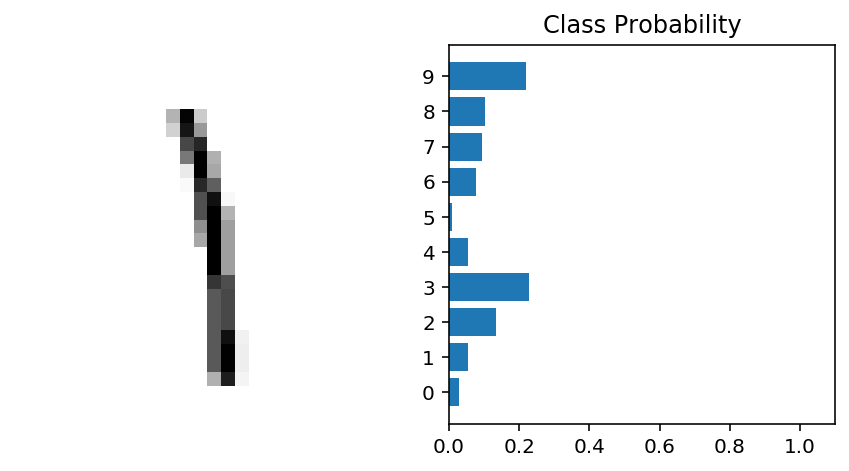

In [30]:
for image_batch, label_batch in training_batches.take(1):
    ps = model.predict(image_batch)
    first_image = image_batch.numpy().squeeze()[0]


fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
ax1.imshow(first_image, cmap = plt.cm.binary)
ax1.axis('off')
ax2.barh(np.arange(10), ps[0])
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)
plt.tight_layout()

모형을 훈련하지 않았기 때문에 위에서 보는 것처럼 제대로 된 결과가 출력되지 않는다. 

## Subclassing with TensorFlow and Keras

`tf.keras.Sequential` model 는 단순하게 layer를 쌓아서 모형을 생성한다. `tf.keras`에는 유연하게 fully-customizable models을 생성할 수 있는 기능을 제공한다. 이를 `tf.keras.Model` 을 사용한 subclassing으로 모형을 define하고 forward pass를 구현할 수 있다. 

앞에서 생성한 동일한 모형을 `tf.keras.Model`을 사용하여 구현하도록 한다.

In [31]:
class Network(tf.keras.Model):
    def __init__(self, num_classes = 2):
        super().__init__()
        self.num_classes = num_classes
    
        # Define layers 
        self.input_layer = tf.keras.layers.Flatten()
        self.hidden_layer = tf.keras.layers.Dense(256, activation = 'relu')
        self.output_layer = tf.keras.layers.Dense(self.num_classes, activation = 'softmax')
    
    # Define forward Pass   
    def call(self, input_tensor):
        x = self.input_layer(input_tensor)
        x = self.hidden_layer(x)
        x = self.output_layer(x)
    
        return x 

하나씩 살펴보자.

```python
class Network(tf.keras.Model):
```

`tf.keras.Model`을 상속한다.`super().__init__()`로 method와 attribute를 사용할 수 있다. `tf.keras.Model` 을 상속하는 것은 필수이다. 생성하는 class의 이름은 어떤 것을 쓰던지 상관이 없다. 

 `__init__` method 에서 우리가 사용하고자 하는 layer를 기술한다. `__init__` method의 `num_classes` argument를 사용한다.

```python
self.input = tf.keras.layers.Flatten()
```

첫번째 layer는 flatten 역할을 수행한다. 

```python
self.hidden = tf.keras.layers.Dense(256, activation = 'relu')
```

두번째 layer는 fully-connected (dense) layer 로 256 neurons과 ReLu activation function함수를 포함한다.

```python
self.output = tf.keras.layers.Dense(self.num_classes, activation = 'softmax')
```

세번째 layer는 마지막 layer로 output layer이다. fully-connected (dense) layer로 `self.num_classes`개의 neurons과 softmax activation function를 사용한다.


그 다음은 forward pass 로  `call` method이다.

```python
def call(self, input_tensor):
```

tensorflow에서 모형을 생성할 때 `tf.keras.Model` 에서 `call` method는 반드시 주어야 한다. `call` method에서는 `input_tensor`를 받아서 `__init__` method에서 선언한 layer들을 통과하는 forward pass를 기술한다.

```python
x = self.input(input_tensor)
x = self.hidden(x)
x = self.output(x)
```

 `input_tensor`는 `input` layer--> `hidden` layer--> `output` layer를 순서대로 통과한다. `__init__` method 에서는 순서가 중요하지 않지만  `call` method에서는 forward pass를 순서대로 기술하는 것이 중요하다. 

`model` object로 우리의 모형이 정의된다.  input tensor의 shape를 명시적으로 지정하지 않았다. 이 예제의 경우, weights 와 biases는 `build(batch_input_shape)`가 호출될 때 또는 training/evaluation method (`.fit` 또는 `.evaluate`)가 호출이 될 때 초기화가 실행된다. 

`model` object를 생성하고  `build()`메소드를 호출한다.

In [32]:
# Create a model object
subclassed_model = Network(10)

# Build the model, i.e. initialize the model's weights and biases
subclassed_model.build((None, 28, 28, 1))

subclassed_model.summary()

Model: "network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          multiple                  0         
_________________________________________________________________
dense_5 (Dense)              multiple                  200960    
_________________________________________________________________
dense_6 (Dense)              multiple                  2570      
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________


`None` 은 임의의 정수를 의미한다. 따라서 이 예제에서 `None`은 어떠한 batch size도 가능하다는 것을 의미한다.

subclassing은 모형에 융통성과 유연성을 준다. 그러나 에러가 발생하면 디버그 하기 힘들어 진다.

### Your Turn to Build a Neural Network

<img src="./assets/mlp_mnist.png" width=600px>

> **실습하기:** subclassing method를 사용하여 784 input units의 layer,  128 units 과 ReLU activation 함수로 hidden layer를 구성한다. 두번째 hidden layer는 64 units 과  ReLU activation로 구성한다. 그리고 마지막 output layer는 10 units으로 활성화 함수는 softmax activation function를 사용한다. `activation = 'relu'`로 activation함수를 지정한다.모형을 생성하고 model object를 생성하고 build 한다.

In [33]:

## Solution

class My_Network(tf.keras.Model):
    def __init__(self, num_classes = 10):
        super().__init__()
        self.num_classes = num_classes
    
        self.input_layer = tf.keras.layers.Flatten()
        self.hidden_1 = tf.keras.layers.Dense(128, activation = 'relu')
        self.hidden_2 = tf.keras.layers.Dense(64, activation = 'relu')
        self.output_layer = tf.keras.layers.Dense(self.num_classes, activation = 'softmax')
    
    def call(self, input_tensor):
        x = self.input_layer(input_tensor)
        x = self.hidden_1(x)
        x = self.hidden_2(x)
        x = self.output_layer(x)
    
        return x

my_model_2 = My_Network()

my_model_2.build((None, 28, 28, 1))

my_model_2.summary()

Model: "my__network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          multiple                  0         
_________________________________________________________________
dense_7 (Dense)              multiple                  100480    
_________________________________________________________________
dense_8 (Dense)              multiple                  8256      
_________________________________________________________________
dense_9 (Dense)              multiple                  650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


## Looking at Weights and Biases of Subclassed Models

앞선 예제에서 본 것과 같이 각 layer의 weights 와 biases를 확인할 수 있다. 이 예제에서는 `__init__` method에서 정의한 각 layer를 확인할 수 있다. 예를 들어 첫번째 hidden layer의 이름은 `hidden_1`이고, 이름으로 해당 layer의 weights 와 biases 를 화면에 출력할 수 있다:

In [34]:
w1 = my_model_2.hidden_1.get_weights()[0]
b1 = my_model_2.hidden_1.get_weights()[1]

print('\n\u2022 Weights:\n', w)
print('\n\u2022 Biases:\n', b)
print('\nThis layer has a total of {:,} weights and {:,} biases'.format(w1.size, b1.size))


• Weights:
 [[ 0.13460496  0.08439663  0.10001439 ... -0.06910092  0.08547229
   0.04187778]
 [-0.02884597 -0.13571478  0.14215145 ... -0.03963515 -0.05197094
  -0.07258549]
 [ 0.03209706 -0.10026196 -0.11505969 ...  0.05634196  0.04823108
   0.00201425]
 ...
 [-0.06065531 -0.05637437  0.13848048 ...  0.14588565  0.09817441
  -0.01468949]
 [ 0.07664064  0.05158514 -0.05301372 ...  0.03432518  0.06342009
  -0.08254348]
 [-0.05531436  0.1244688   0.09550743 ...  0.03989328 -0.08527832
  -0.05829627]]

• Biases:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

This layer has a total of 100,352 weights and 128 biases


## Making Predictions with Subclassed Models

예측 또한 앞에서 본 예제와 동일하게 수행하면 된다.

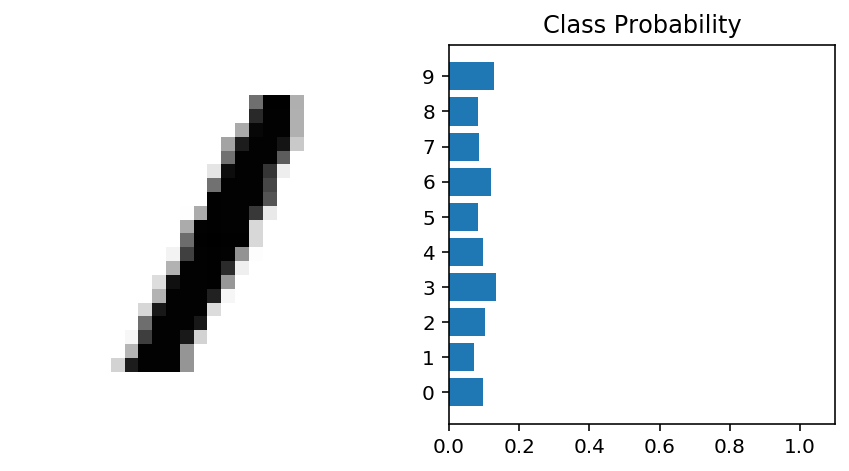

In [35]:
for image_batch, label_batch in training_batches.take(1):
    ps = subclassed_model.predict(image_batch)
    first_image = image_batch.numpy().squeeze()[0]

fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
ax1.imshow(first_image, cmap = plt.cm.binary)
ax1.axis('off')
ax2.barh(np.arange(10), ps[0])
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)
plt.tight_layout()

모형의 훈련을 아직 진행하지 않았으므로 예측 결과는 정확하지 않다. 

## Other Methods to Create Models

In [36]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Flatten(input_shape = (28,28,1)))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))
          
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                25120     
_________________________________________________________________
dense_11 (Dense)             (None, 10)                330       
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


In [37]:
layer_neurons = [512, 256, 128, 56, 28, 14]

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape = (28,28,1)))

for neurons in layer_neurons:
    model.add(tf.keras.layers.Dense(neurons, activation='relu'))
            
model.add(tf.keras.layers.Dense(10, activation='softmax'))
          
model.summary()        

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_13 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_14 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_15 (Dense)             (None, 56)                7224      
_________________________________________________________________
dense_16 (Dense)             (None, 28)                1596      
_________________________________________________________________
dense_17 (Dense)             (None, 14)               

## Clearing the Graph

이전 모형과 헷갈리는 것을 방지하기 위해 다음과 같이 실행 할 수 있다:

```python
tf.keras.backend.clear_session()
```

이 명령어는 `tf.keras` graph를  새로 생성한다.

In [38]:
tf.keras.backend.clear_session()

layer_neurons = [512, 256, 128, 56, 28, 14]

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape = (28,28,1)))

for neurons in layer_neurons:
    model.add(tf.keras.layers.Dense(neurons, activation='relu'))
            
model.add(tf.keras.layers.Dense(10, activation='softmax'))
          
model.summary()    

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 56)                7224      
_________________________________________________________________
dense_4 (Dense)              (None, 28)                1596      
_________________________________________________________________
dense_5 (Dense)              (None, 14)                4